# Exploratory Data Analysis with Pyspark and Spark SQL

The following notebook utilizes New York City taxi data from [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

## Instructions

- Load and explore nyc taxi data from january 0f 2019. The exercises can be executed using pyspark or spark sql ( a subset of the questions will be re-answered using the language not chosen for the  main work).
- Load the zone lookup table to answer the questions about the nyc boroughs.  
- Load nyc taxi data from January of 2025 and compare data.  
- With any remaining time, work on the where to go from here section.  
- Lab due date is TBD ( due dates will be updated in the readme for the class repo )

In [0]:
# Define the name of the new catalog
catalog = 'taxi_eda_db'

# define variables for the trips data
schema = 'yellow_taxi_trips'
volume = 'data'
file_name = 'yellow_tripdata_2019-01.parquet'
table_name = 'tbl_yellow_taxi_trips'
path_volume = '/Volumes/' + catalog + "/" + schema + '/' + volume
path_table =  catalog + "." + schema
download_url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-01.parquet'

In [0]:
# create the catalog/schema/volume
spark.sql('create catalog if not exists ' + catalog)
spark.sql('create schema if not exists ' + catalog + '.' + schema)
spark.sql('create volume if not exists ' + catalog + '.' + schema + '.' + volume)

DataFrame[]

In [0]:
# Get the data
dbutils.fs.cp(f"{download_url}", f"{path_volume}" + "/" + f"{file_name}")

True

In [0]:
# create the dataframe
df_trips = spark.read.parquet(f"{path_volume}/{file_name}",
  header=True,
  inferSchema=True,
  sep=",")

In [0]:
# Show the dataframe
df_trips.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2019-01-01 00:46:40|  2019-01-01 00:53:20|            1.0|          1.5|       1.0|                 N|         151|         239|           1|        7.0|  0.5|    0.5|      1.6

## Lab

### Part 1
This section can be completed either using pyspark commands or sql commands ( There will be a section after in which a self-chosen subset of the questions are re-answered using the language not used for the main section. i.e. if pyspark is chosen for the main lab, sql should be used to repeat some of the questions. )

- Add a column that creates a unique key to identify each record in order to answer questions about individual trips
- Which trip has the highest passanger count
- What is the Average passanger count
- Shortest/longest trip by distance? by time?.
- busiest day/slowest single day
- busiest/slowest time of day ( you may want to bucket these by hour or create timess such as morning, afternoon, evening, late night )
- On average which day of the week is slowest/busiest
- Does trip distance or num passangers affect tip amount
- What was the highest "extra" charge and which trip
- Are there any datapoints that seem to be strange/outliers (make sure to explain your reasoning in a markdown cell)?

In [0]:
from pyspark.sql.functions import col, monotonically_increasing_id, max, min, avg, count, hour, dayofweek, to_date, unix_timestamp

# 1. Add a column that creates a unique key 
df_trips = df_trips.withColumn("trip_id", monotonically_increasing_id())

# 2. trip with the highest passanger count
df_trips.orderBy(col("passenger_count").desc()).select("trip_id","passenger_count").show(1)

# 3. the Average passanger count
df_trips.agg(avg("passenger_count")).show()

# 4. Shortest/longest trip by distance?.
df_trips.orderBy(col("trip_distance").asc()).select("trip_id","trip_distance").show(1)
df_trips.orderBy(col("trip_distance").desc()).select("trip_id","trip_distance").show(1)

# 5. Shortest/longest trip by time?.
df_trips = df_trips.withColumn("trip_time", 
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60)
df_trips.orderBy(col("trip_time").asc()).select("trip_id","trip_time").show(1)
df_trips.orderBy(col("trip_time").desc()).select("trip_id","trip_time").show(1)

# 6. busiest day/slowest single day
df_trips.groupBy(to_date("tpep_pickup_datetime").alias("day")) \
    .agg(count("*").alias("nb_trips")) \
    .orderBy(col("nb_trips").desc()).show(5)

# 7. busiest/slowest time of day 
df_trips.groupBy(hour("tpep_pickup_datetime").alias("hour")) \
    .agg(count("*").alias("nb_trips")) \
    .orderBy(col("nb_trips").desc()).show()

# 8. On average which day of the week is slowest/busiest
df_trips.groupBy(dayofweek("tpep_pickup_datetime").alias("weekday")) \
    .agg(count("*").alias("nb_trips")) \
    .orderBy(col("nb_trips").desc()).show()

# 9. trip distance or num passangers affect tip amount
df_trips.groupBy("passenger_count").agg(avg("tip_amount")).orderBy("passenger_count").show()
df_trips.groupBy().agg(avg("tip_amount").alias("avg_tip"), avg("trip_distance").alias("avg_distance")).show()

# 10. highest "extra"
df_trips.orderBy(col("extra").desc()).select("trip_id","extra").show(1)


+-------+---------------+
|trip_id|passenger_count|
+-------+---------------+
| 949956|            9.0|
+-------+---------------+
only showing top 1 row
+--------------------+
|avg(passenger_count)|
+--------------------+
|  1.5670317144945614|
+--------------------+

+-------+-------------+
|trip_id|trip_distance|
+-------+-------------+
|      2|          0.0|
+-------+-------------+
only showing top 1 row
+-------+-------------+
|trip_id|trip_distance|
+-------+-------------+
|6074091|        831.8|
+-------+-------------+
only showing top 1 row
+-------+---------+
|trip_id|trip_time|
+-------+---------+
|1203184| -84280.5|
+-------+---------+
only showing top 1 row
+-------+-----------------+
|trip_id|        trip_time|
+-------+-----------------+
|  68267|43648.01666666667|
+-------+-----------------+
only showing top 1 row
+----------+--------+
|       day|nb_trips|
+----------+--------+
|2019-01-25|  292499|
|2019-01-11|  291714|
|2019-01-31|  284625|
|2019-01-17|  284580|
|2019

### Part 2

- Using the code for loading the first dataset as an example, load in the taxi zone lookup and answer the following questions
- which borough had most pickups? dropoffs?
- what are the busy/slow times by borough 
- what are the busiest days of the week by borough?
- what is the average trip distance by borough?
- what is the average trip fare by borough?
- highest/lowest faire amounts for a trip, what burough is associated with the each
- load the dataset from the most recently available january, is there a change to any of the average metrics.

In [0]:
from pyspark.sql.functions import col, avg, count

# Télécharger et copier le fichier dans DBFS
download_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
path_volume = f"/Volumes/{catalog}/{schema}/{volume}"
file_name = "taxi_zone_lookup.csv"

dbutils.fs.cp(download_url, f"{path_volume}/{file_name}")

# Charger le CSV depuis DBFS
zones = spark.read.csv(f"{path_volume}/{file_name}", header=True, inferSchema=True)
zones.show(5)

# -----------------------------
# Joindre pickup
df_borough = df_trips.join(zones, df_trips.PULocationID == zones.LocationID, "left") \
                     .withColumnRenamed("Borough","pickup_borough")

# Pickups par borough
df_borough.groupBy("pickup_borough") \
          .agg(count("*").alias("nb_pickups")) \
          .orderBy(col("nb_pickups").desc()).show()

# -----------------------------
# Joindre dropoff
df_borough2 = df_trips.join(zones, df_trips.DOLocationID == zones.LocationID, "left") \
                      .withColumnRenamed("Borough","dropoff_borough")

df_borough2.groupBy("dropoff_borough") \
           .agg(count("*").alias("nb_dropoffs")) \
           .orderBy(col("nb_dropoffs").desc()).show()

# -----------------------------
# Distance moyenne par borough
df_borough.groupBy("pickup_borough").agg(avg("trip_distance").alias("avg_distance")).show()

# Fare moyen par borough
df_borough.groupBy("pickup_borough").agg(avg("fare_amount").alias("avg_fare")).show()


+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows
+--------------+----------+
|pickup_borough|nb_pickups|
+--------------+----------+
|     Manhattan|   6950965|
|        Queens|    471173|
|       Unknown|    159815|
|      Brooklyn|     91905|
|         Bronx|     18062|
|           N/A|      3890|
|           EWR|       446|
| Staten Island|       361|
+--------------+----------+

+---------------+-----------+
|dropoff_borough|nb_dropoffs|
+---------------+-----------+


### Part 3

- choose 3 questions from above and re-answer them using the language you did not use for the main notebook . (i.e - if you completed the exercise in python, redo 3 questions in pure sql) . at least one of the questions to be redone must involve a join

In [0]:
df_trips.createOrReplaceTempView("trips")
zones.createOrReplaceTempView("zones")

# 1. Trajet avec plus de passagers
spark.sql("""
SELECT trip_id, passenger_count 
FROM trips 
ORDER BY passenger_count DESC LIMIT 1
""").show()

# 2. Pickups par borough (join SQL)
spark.sql("""
SELECT z.Borough, COUNT(*) as nb_pickups
FROM trips t
JOIN zones z ON t.PULocationID = z.LocationID
GROUP BY z.Borough
ORDER BY nb_pickups DESC
""").show()

# 3. Distance moyenne par jour
spark.sql("""
SELECT DATE(tpep_pickup_datetime) as day, AVG(trip_distance) as avg_distance
FROM trips
GROUP BY day
ORDER BY avg_distance DESC
""").show()


+-------+---------------+
|trip_id|passenger_count|
+-------+---------------+
| 949956|            9.0|
+-------+---------------+

+-------------+----------+
|      Borough|nb_pickups|
+-------------+----------+
|    Manhattan|   6950965|
|       Queens|    471173|
|      Unknown|    159815|
|     Brooklyn|     91905|
|        Bronx|     18062|
|          N/A|      3890|
|          EWR|       446|
|Staten Island|       361|
+-------------+----------+

+----------+------------------+
|       day|      avg_distance|
+----------+------------------+
|2019-02-13|             12.98|
|2019-04-07|              6.78|
|2019-05-20|              5.64|
|2019-08-13|              5.37|
|2018-12-31| 3.561594202898551|
|2019-01-01| 3.542516364711293|
|2018-12-30|3.4366666666666665|
|2009-01-01|            3.2654|
|2019-01-02| 3.239077272978863|
|2008-12-31|3.1618181818181825|
|2019-02-23|              3.16|
|2019-07-23|              3.13|
|2019-01-27|3.1096918589618747|
|2019-01-06|3.0946083046407082|



### Part 4

As of spark v4 dataframes have native visualization support. Choose at least 3 questions from above and provide visualizations.


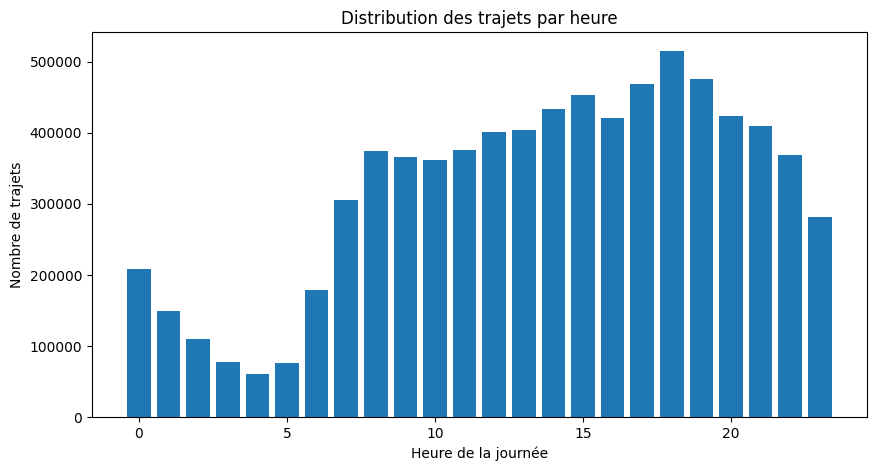

In [0]:
import matplotlib.pyplot as plt

# Exemple : nombre de trajets par heure
hourly = df_trips.groupBy(hour("tpep_pickup_datetime").alias("hour")) \
                 .agg(count("*").alias("nb_trips")).toPandas()

plt.figure(figsize=(10,5))
plt.bar(hourly["hour"], hourly["nb_trips"])
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de trajets")
plt.title("Distribution des trajets par heure")
plt.show()


# Where to go from here

- Continue building the dataset by loading in more data, start by completing the data for 2019 and calculating the busiest season (fall, winter, spring, summer)
- Explore a dataset/datasets of your choosing